In [91]:
# IMPORTS
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import cv2
import numpy as np
import matplotlib.pyplot as plt
import logging
from math import log2
import skimage.transform as st
from tqdm import tqdm
from IPython.display import clear_output
from time import sleep

# FOR MAC
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# CONFIG CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device))
if str(device) == 'cuda':
  print(torch.cuda.get_device_name())

# TRANSITION DATA FROM DRIVE AND UNZIP
# !cp /content/drive/MyDrive/64_mat.zip /content/64_mat.zip
# !unzip /content/64_mat.zip

# UPLOADING IMAGES
images = np.load('64_mat.npy')
print(images.shape)

device: cuda
A100-SXM4-40GB
(56611, 64, 64, 3)


![](https://machinelearningmastery.com/wp-content/uploads/2019/06/Summary-of-the-StyleGAN-Generator-Model-Architecture.png)

In [175]:
# CLASSES

# gen conv block 
class GenConvBlock(nn.Module):

  def __init__(self, in_c, out_c, hidden_c, do_scale=True):
    super(GenConvBlock, self).__init__()
    self.do_scale = do_scale
    self.out_c = out_c
    self.hidden_c = hidden_c
    self.conv1 = nn.Conv2d(in_c, hidden_c, 3, 1, 1)
    self.conv2 = nn.Conv2d(hidden_c, out_c, 3, 1, 1)
    self.selu = nn.SELU()
    self.gen_noise = torch.randn_like
    self.upsample = F.interpolate
    self.z_2_w = nn.Sequential(*([nn.Linear(265,265)]+
                                 [nn.Linear(265,265) for i in range(6)]))
    self.y_scale0 = nn.Linear(265,hidden_c)
    self.y_scale1 = nn.Linear(265,out_c)
    self.y_shift0 = nn.Linear(265,hidden_c)
    self.y_shift1 = nn.Linear(265,out_c)
    self.noise_factor = 0.01
  
  def forward(self, x):
    
    x = self.upsample(x, scale_factor=2) if self.do_scale else x
    x = self.selu(self.conv1(x))
    noise = self.gen_noise(x).to(device)
    x = x + noise*self.noise_factor
    x = self.AdaIN(x, 0)
    x = self.selu(self.conv2(x))
    noise = self.gen_noise(x).to(device)
    x = x + noise*self.noise_factor
    x = self.AdaIN(x, 1)
    return x

  def AdaIN(self, x, iter, ys=None):
    ys = torch.randn((x.shape[0], 265)).to(device) if ys is None else ys
    for layer in range(7):
      ys = self.z_2_w[layer](ys)
      ys = self.selu(ys)
    if iter == 0:
      y_scale = self.y_scale0(ys)
      y_shift = self.y_shift0(ys)
    else:
      y_scale = self.y_scale1(ys)
      y_shift = self.y_shift1(ys)
    y_scale = y_scale.view((x.shape[0],x.shape[1],1,1))
    y_shift = y_shift.view((x.shape[0],x.shape[1],1,1))
    mean = torch.mean(x, dim=[2,3]).view((x.shape[0],x.shape[1],1,1)) 
    sigma = torch.std(x, dim=[2,3]).view((x.shape[0],x.shape[1],1,1))
    x = (x - mean)/ sigma
    x = x * y_scale + y_shift
    return x

# des conv block 
class DesConvBlock(nn.Module):

  def __init__(self, in_c, out_c, hidden_c, use_in=True):
    super(DesConvBlock, self).__init__()
    self.use_in = use_in
    self.conv1 = nn.Conv2d(in_c, hidden_c, 3, 1, 1)
    self.conv2 = nn.Conv2d(hidden_c, out_c, 3, 1, 1)
    self.selu = nn.SELU()
    self.downsample = nn.MaxPool2d(2)
    self.adain1 = nn.InstanceNorm2d(hidden_c,affine=True)
    self.adain2 = nn.InstanceNorm2d(out_c,affine=True)
  
  def forward(self, x):

    x = self.selu(self.conv1(x))
    x = self.adain1(x) if self.use_in else x
    x = self.downsample(x)
    x = self.conv2(x)
    x = self.selu(x)
    x = self.adain2(x) if self.use_in else x
    return x

# generator
class Generator(nn.Module):
  def __init__(self, batch_size):
    super(Generator, self).__init__()
    self.batch_size = batch_size
    self.conv_blocks = nn.ModuleList([GenConvBlock(265,265,265,do_scale=False),
                                      GenConvBlock(265,265,265),
                                      GenConvBlock(265,265,265),
                                      GenConvBlock(265,265,265),
                                      GenConvBlock(265,265,265)])
    self.rgb_layers = nn.ModuleList([nn.Conv2d(265, 3, 1, 1, 0),
                                     nn.Conv2d(265, 3, 1, 1, 0),
                                     nn.Conv2d(265, 3, 1, 1, 0),
                                     nn.Conv2d(265, 3, 1, 1, 0),
                                     nn.Conv2d(265, 3, 1, 1, 0)])
    self.inital_value = nn.Parameter(torch.randn(1,265,4,4))

  def forward(self, to_scale):
    num_steps = int(log2(to_scale) - 1)
    iv = self.inital_value.repeat(self.batch_size,1,1,1)
    value = torch.clone(iv).float().to(device)
    for step in range(num_steps):
      value = self.conv_blocks[step](value)
    output = self.rgb_layers[num_steps - 1](value)
    return output

# discriminator
class Descirimator(nn.Module):
  def __init__(self):
    super(Descirimator, self).__init__()
    self.conv_blocks = nn.ModuleList([DesConvBlock(265,265,265, use_in=False)]
                                     +[DesConvBlock(265,265,265)]*4)
    self.rgb_layers = nn.ModuleList([nn.Conv2d(3, 265, 1, 1, 0)]*5)
    self.downsample = nn.MaxPool2d(2)
    self.final_conv = nn.Conv2d(265, 1, 1, 1, 0)

  def forward(self, x, from_scale):
    num_steps = int(log2(from_scale) - 1)
    value = self.rgb_layers[num_steps-2](x)
    for step in range(num_steps):
      value = self.conv_blocks[step](value)
    value = self.downsample(value)
    value = self.final_conv(value)
    return value

In [100]:
# TESTS

def test_gen_conv_block():
  conv_block = GenConvBlock(100,3, 110, do_scale=True).to(device)
  target = rescale_image(images[0,:,:,:], 16)
  target = torch.Tensor(target).float().to(device)
  target = target.unsqueeze(0).swapdims(1,3)
  target = target.repeat(32,1,1,1)
  loss = nn.MSELoss()
  opt = optim.Adam(conv_block.parameters(), lr=0.001)
  losses = []
  input = torch.randn((32,100,8,8)).to(device)
  for i in range(350):
    output = conv_block(input)
    opt.zero_grad()
    l = loss(output, target)
    losses.append(l.item())
    l.backward()
    opt.step()
  f, a = plt.subplots(1,3, figsize=(18,4))
  a[0].plot(losses)
  a[1].imshow(target[0,:,:,:].swapdims(0,2).cpu().detach().numpy())
  a[2].imshow(output[0,:,:,:].swapdims(0,2).cpu().detach().numpy())

def test_des_conv_block():
  conv_block = DesConvBlock(100,3, 110, do_scale=True).to(device)
  target = rescale_image(images[0,:,:,:], 16)
  target = torch.Tensor(target).float().to(device)
  target = target.unsqueeze(0).swapdims(1,3)
  target = target.repeat(32,1,1,1) 
  loss = nn.MSELoss()
  opt = optim.Adam(conv_block.parameters(), lr=0.001)
  losses = []
  input = torch.randn((32,100,32,32)).to(device)
  for i in range(1500):
    output = conv_block(input)
    opt.zero_grad()
    l = loss(output, target)
    losses.append(l.item())
    l.backward()
    opt.step()
  f, a = plt.subplots(1,3, figsize=(18,4))
  a[0].plot(losses)
  a[1].imshow(target[0,:,:,:].swapdims(0,2).cpu().detach().numpy())
  a[2].imshow(output[0,:,:,:].swapdims(0,2).cpu().detach().numpy())

def test_generator():
  g = Generator(32).to(device)
  target = rescale_image(images[0,:,:,:], 64)
  target = torch.Tensor(target).float().to(device)
  target = target.unsqueeze(0).swapdims(1,3)
  target = target.repeat(32,1,1,1) 
  loss = nn.MSELoss()  
  opt = optim.Adam(g.parameters(), lr=0.001)
  losses = []
  for i in range(450):
    output = g(64)
    opt.zero_grad()
    l = loss(output, target)
    losses.append(l.item())
    l.backward()
    opt.step()
  f, a = plt.subplots(1,3, figsize=(18,4))
  a[0].plot(losses)
  a[1].imshow(target[0,:,:,:].swapdims(0,2).cpu().detach().numpy())
  a[2].imshow(output[0,:,:,:].swapdims(0,2).cpu().detach().numpy())   

def test_descriminator():
  d = Descirimator().to(device)
  target = torch.zeros([32,1,1,1]).to(device)
  loss = nn.MSELoss()  
  opt = optim.Adam(d.parameters(), lr=0.001)
  losses = []
  input = rescale_image(images[0,:,:,:], 64)
  input = torch.Tensor(input).float().to(device)
  input = input.unsqueeze(0).swapdims(1,3)
  input = input.repeat(32,1,1,1) 
  for i in range(50):
    output = d(input, 64)
    opt.zero_grad()
    l = loss(output, target)
    losses.append(l.item())
    l.backward()
    opt.step()
  print(torch.mean(output))
  plt.plot(losses)

In [174]:
# UTILITY FUNCS
def rescale_image(im, scale):
  return st.resize(im, (scale, scale))

def chain(*iterables):
    '''can be used to unite two generators'''
    for it in iterables:
        for element in it:
            yield element
            
def wasserstein_loss(y_true, y_pred):
  return torch.mean(y_true*y_pred.squeeze())

def merge_images_and_predict(fake, real, d, scale, batch_size=32):
  a = torch.rand((BATCH_SIZE,1,1,1)).float().to(device)
  mean_images = real*a+fake*(1-a)
  y_pred = d(mean_images, scale).squeeze()
  return mean_images, y_pred

def gradiant_panelty(mean_images, y_pred):
  ones = torch.ones_like(y_pred)
  grad_params = torch.autograd.grad(outputs=y_pred,inputs=mean_images
                                    ,create_graph=True,grad_outputs=ones)[0]
  grad_params = grad_params.reshape(grad_params.shape[0], -1)
  gradient_norm = grad_params.norm(2, dim=1)
  gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
  return gradient_penalty

class Dataset(torch.utils.data.Dataset):

  def __init__(self, data, scale):
    self.data = data
    self.scale = scale

  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self, i):
    im = self.data[i,:,:,:]
    im = st.resize(im, (self.scale, self.scale))
    im = im.swapaxes(0,2)
    return im

def get_loader(img_size, images):

  dataset = Dataset(images, img_size)
  loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                       shuffle=True, drop_last=True,
                                       pin_memory=True)
  return loader, dataset

In [4]:
def train(scale, lr=0.0001, train_whole=False, e=0, b=0):
  g.train()
  d.train()
  loader, dataset = get_loader(scale, images)
  step = int(log2(scale)-2)
  g_params = chain(g.conv_blocks[step].parameters(),g.rgb_layers[step].parameters())
  if scale == 4:
    data_iter = iter([g.inital_value])
    g_params = chain(g_params, data_iter)
  if train_whole:
    g_params = g.parameters()
  opt_g = optim.Adam(g_params,lr = lr, betas=(0., 0.99))
  opt_d = optim.Adam(d.parameters() ,lr = lr, betas=(0., 0.99))
  loop = tqdm(loader, leave=True)
  y_true = torch.ones(BATCH_SIZE*2).to(device)
  y_true[:BATCH_SIZE] *= -1

  for batch_idx, real in enumerate(loop):
    b += 1
    if batch_idx % 30 == 0 and batch_idx > 0:
      clear_output(wait=True)
      plt.imshow(fake[0,:,:,:].swapaxes(0,2).cpu().detach().numpy())
      plt.axis('off')
      plt.title(f'apoch: {e}, batches:{b}')
      plt.show()
    real = real.float().to(device)

    # train discriminator
    if batch_idx % 5 != 0 or batch_idx == 0:
      fake = g(scale)
      d_real = d(real, scale)
      d_fake = d(fake.detach(), scale)
      mean_images, y_pred = merge_images_and_predict(fake, real, d, scale, batch_size=32)
      gp = gradiant_panelty(mean_images, y_pred)
      predictions = torch.cat([d_fake,d_real])
      w_loss = wasserstein_loss(y_true, predictions)
      loss = w_loss + LAMBDA_GP * gp
      opt_d.zero_grad()
      loss.backward()
      opt_d.step()

    else:
      # train generator
      fake = g(scale)
      y_pred = d(fake, scale)
      loss = wasserstein_loss(torch.ones(BATCH_SIZE).to(device), y_pred)
      opt_g.zero_grad()
      loss.backward()
      opt_g.step()
  return b

In [5]:
BATCH_SIZE = 32
LAMBDA_GP = 10
g = Generator(BATCH_SIZE).to(device)
d = Descirimator().to(device)

In [180]:
g.load_state_dict(torch.load('/content/g64_e87.pth'))
d.load_state_dict(torch.load('/content/d64_e87.pth'))

<All keys matched successfully>

In [ ]:
b = 0
for i in range(20):
  b = train(4,e=i,b=b)

In [ ]:
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)
logger.setLevel(old_level)
g.eval()
d.eval()
def show_scale_examples(scale):
  out = g(scale)
  c = 0
  f, a = plt.subplots(4,4, figsize=(18,10))
  f.tight_layout(pad=0.1)
  for row in range(2):
    for col in range(4):
      im = out[c,:,:,:].swapaxes(0,2).cpu().detach().numpy()
      c += 1
      a[row,col].imshow(im)
      a[row,col].axis('off')
  for row in range(2,4):
    for col in range(4):
      c = np.random.randint(10000)
      im = st.resize(images[c,:,:,:], (scale, scale))
      a[row,col].imshow(im)
      a[row,col].axis('off')
show_scale_examples(4)
logger.setLevel(old_level)

In [ ]:
b = 0
for i in range(8):
  b = train(8,e=i,b=b)

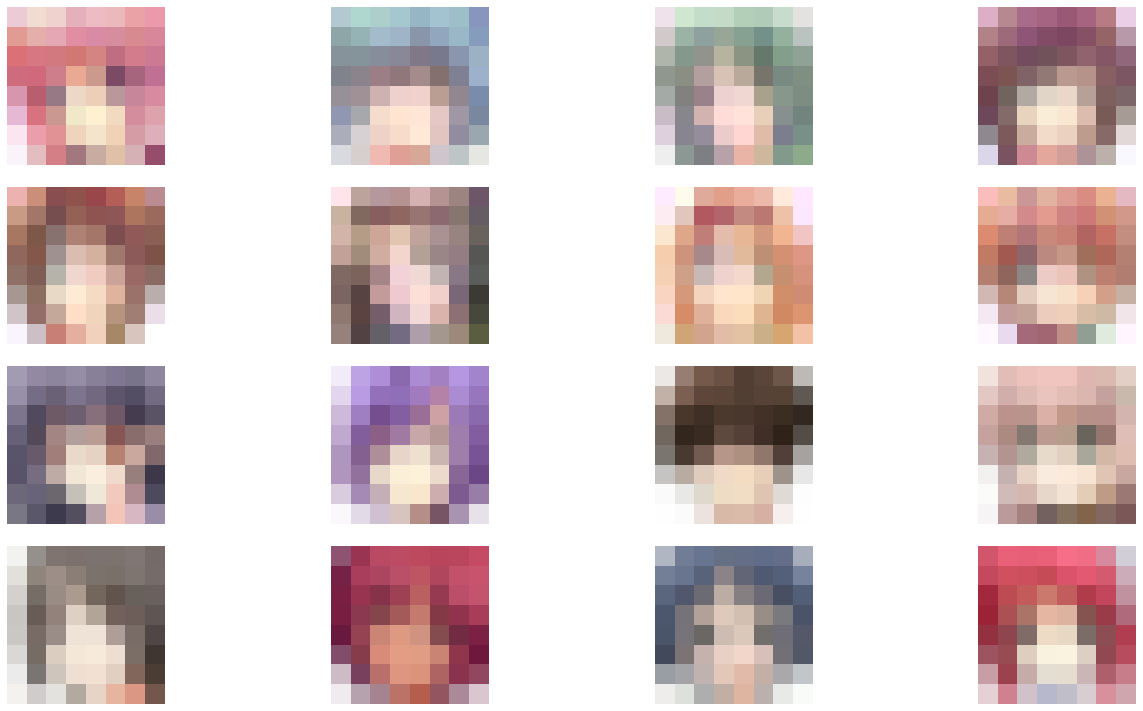

In [160]:
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)
show_scale_examples(8)
logger.setLevel(old_level)

In [ ]:
b = 0
for i in range(9): # 16
  b = train(16,e=i,b=b)

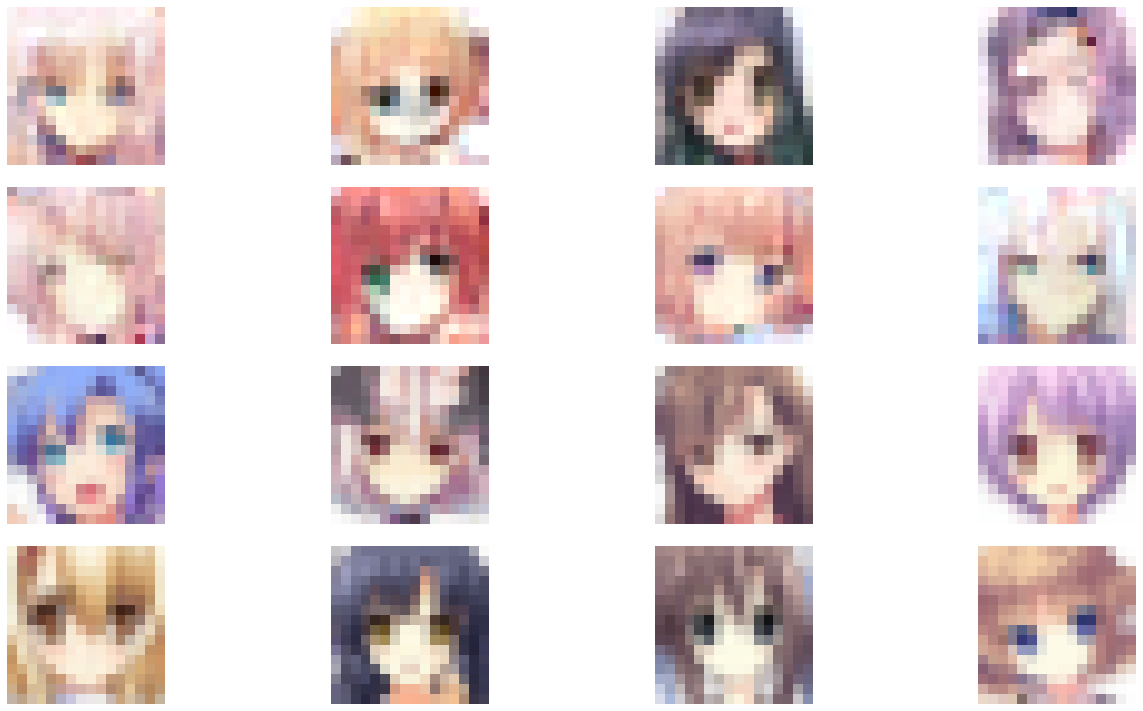

In [164]:
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)
show_scale_examples(16)
logger.setLevel(old_level)

In [ ]:
b = 0
for i in range(2300): # 13
  b = train(32,e=i,b=b, train_whole=True)

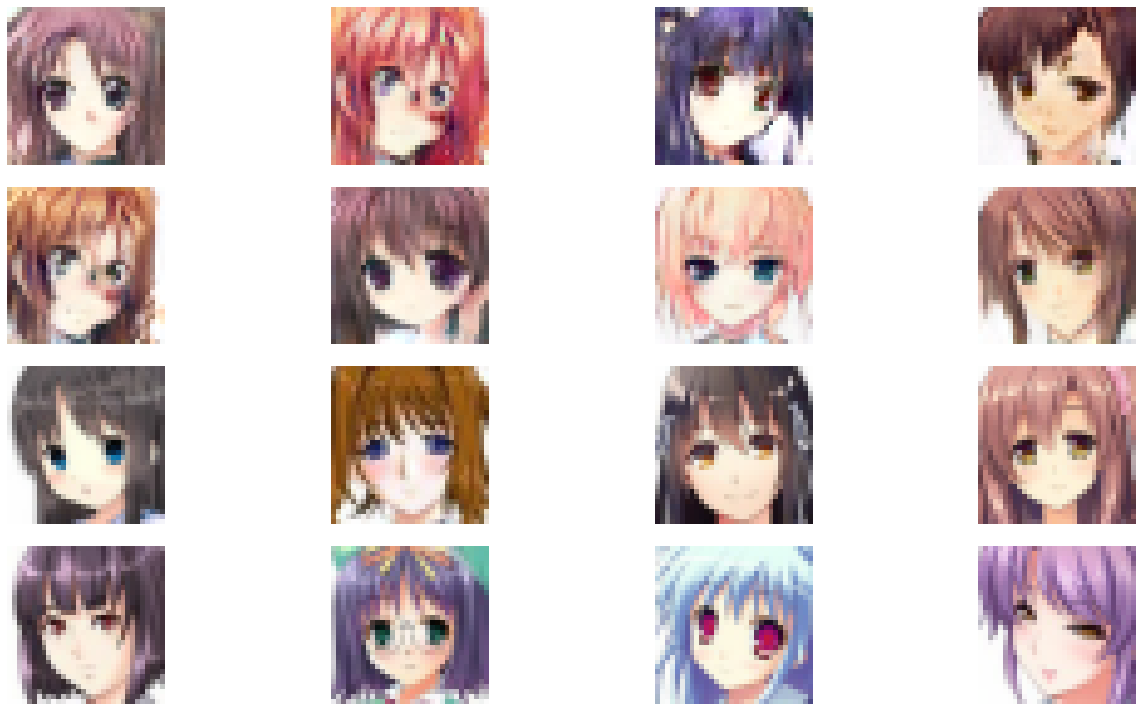

In [11]:
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)
show_scale_examples(32)
logger.setLevel(old_level)

In [ ]:
b = 0
for i in range(1300):
  b = train(64,e=i,b=b, train_whole=True)

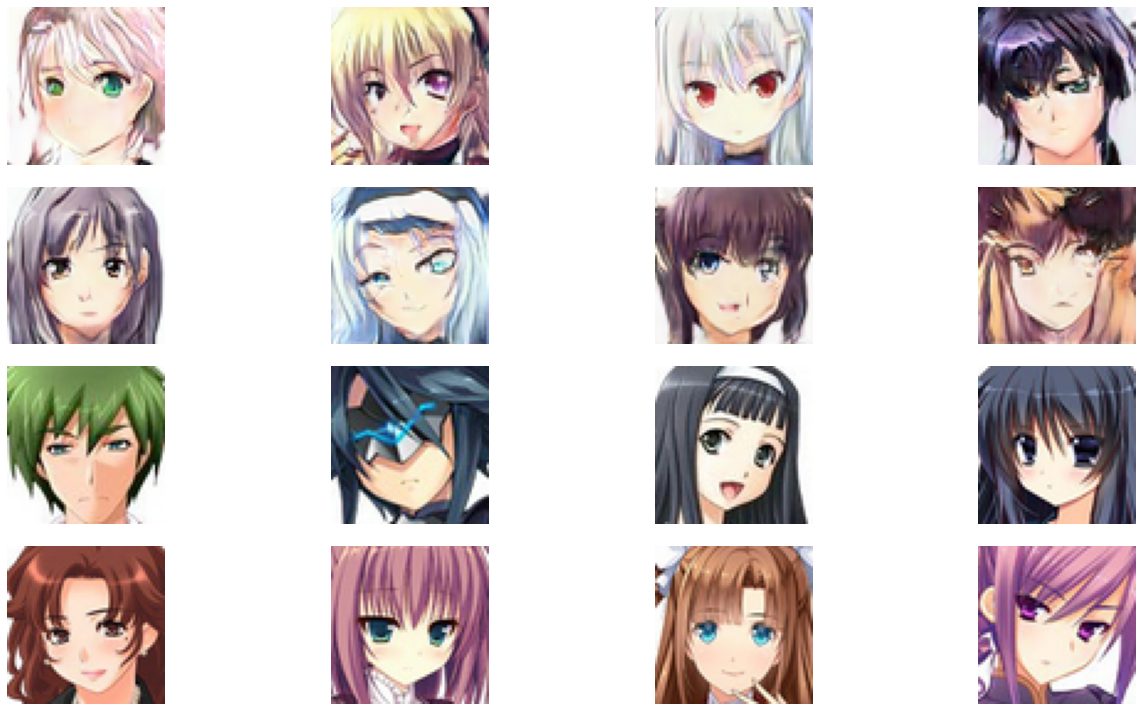

In [181]:
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)
show_scale_examples(64)
logger.setLevel(old_level)

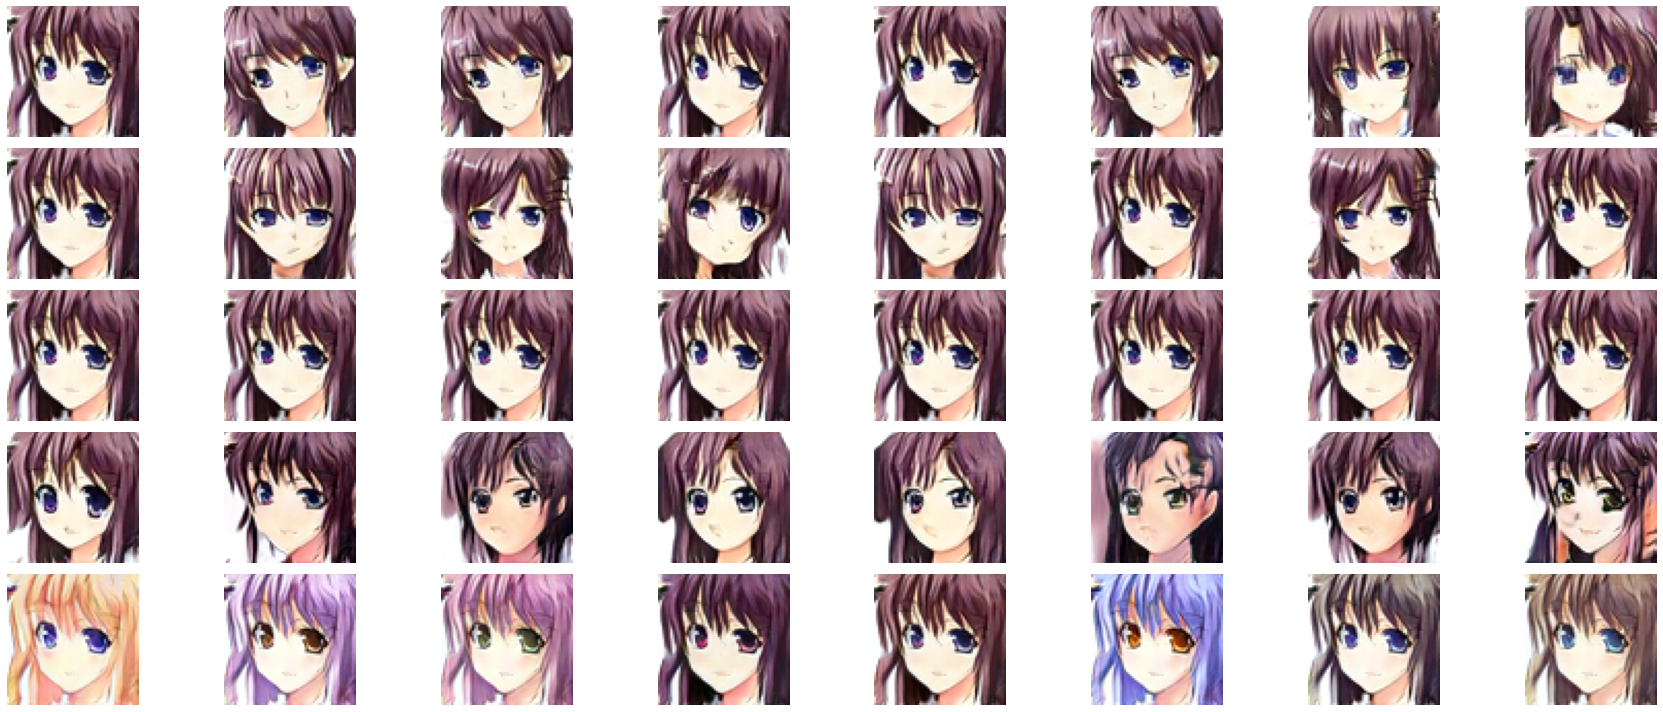

In [98]:
ys = torch.randn((1, 265)).to(device)
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

f, a = plt.subplots(5,8, figsize=(25,10))
for r in range(5):
  for c in range(8):
    change = r
    g.eval()
    for i in range(5):
      if i == 0:
        val = F.selu(g.conv_blocks[i].conv1(g.inital_value))
      else:
        val = F.interpolate(val, scale_factor=2)
        val = F.selu(g.conv_blocks[i].conv1(val))
      noise = torch.randn_like(val)#.to(device)
      val = val + noise*0.03
      if i == change:
        ys_new = torch.randn((1, 265)).to(device)
        val = g.conv_blocks[i].AdaIN(val, 0, ys=ys_new)
      else:
        val = g.conv_blocks[i].AdaIN(val, 0, ys=ys) 
      val = F.selu(g.conv_blocks[i].conv2(val))
      noise = torch.randn_like(val)
      val = val + noise*0.03
      if i == change:
        ys_new = torch.randn((1, 265)).to(device)
        val = g.conv_blocks[i].AdaIN(val, 1, ys=ys_new)
      else:
        val = g.conv_blocks[i].AdaIN(val, 1, ys=ys)
    result = g.rgb_layers[4](val)
    im = result[0,:,:].swapaxes(0,2).cpu().detach().numpy()
    a[r,c].axis('off')
    a[r,c].imshow(im)
f.tight_layout()
logger.setLevel(old_level)



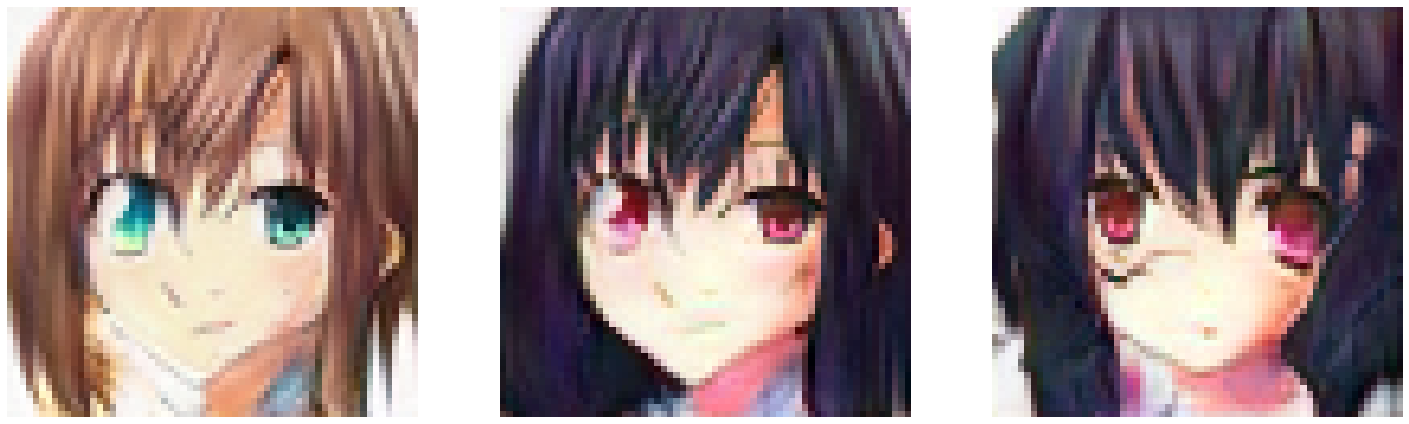

In [208]:
def combine_images():
  ys1 = torch.randn((1, 265)).to(device)
  ys2 = torch.randn((1, 265)).to(device)
  noises = [torch.randn((1,265,x,x)).to(device) for x in [4,8,16,32,64]]  
  f, a = plt.subplots(1,3, figsize=(25,10))
  for balance in range(3):
    if balance == 0:
      inp = ys1
    elif balance == 2:
      inp=ys2
    for i in range(5):
      if balance == 1 and i > 1:
        inp = ys2
      if i == 0:
        val = F.selu(g.conv_blocks[i].conv1(g.inital_value))
      else:
        val = F.interpolate(val, scale_factor=2)
        val = F.selu(g.conv_blocks[i].conv1(val))
      noise = torch.randn_like(val)#.to(device)
      val = val + noises[i]*0.04
      val = g.conv_blocks[i].AdaIN(val, 0, ys=inp)
      val = F.selu(g.conv_blocks[i].conv2(val))
      noise = torch.randn_like(val)
      val = val + noises[i]*0.04
      val = g.conv_blocks[i].AdaIN(val, 1, ys=inp)
    result = g.rgb_layers[4](val)
    im = result[0,:,:].swapaxes(0,2).cpu().detach().numpy()
    a[balance].axis('off')
    a[balance].imshow(im)

combine_images()